In [31]:
import pandas as pd
import numpy as np

data=pd.read_csv('/content/tandrara_fulldata.csv')

In [32]:
data['DATE'] = pd.to_datetime(data['YEAR'].astype(str) + '-' +
                              data['MO'].astype(str) + '-' +
                              data['DY'].astype(str))

data.head()


,YEAR,MO,DY,T2M,PS,WS10M,WD10M,DATE
0,2000,12,1,11.81,87.39,3.20,226.31,2000-12-01
1,2000,12,2,10.55,87.54,3.36,314.00,2000-12-02
2,2000,12,3,8.64,87.56,2.72,310.75,2000-12-03
3,2000,12,4,10.33,87.43,2.80,217.62,2000-12-04
4,2000,12,5,9.24,87.39,3.91,224.06,2000-12-05


In [37]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

features = ['T2M', 'WD10M', 'WS10M', 'PS']
target = 'WS10M'

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[features])
data_scaled = pd.DataFrame(data_scaled, columns=features, index=data.index)

sequence_length = 30  # Number of previous days used for prediction


train_size = int(0.8 * len(data))

train_data = data.iloc[:train_size].copy()
test_data = data.iloc[train_size:].copy()

train_data.head()


,YEAR,MO,DY,T2M,PS,WS10M,WD10M,DATE
0,2000,12,1,11.81,87.39,3.20,226.31,2000-12-01
1,2000,12,2,10.55,87.54,3.36,314.00,2000-12-02
2,2000,12,3,8.64,87.56,2.72,310.75,2000-12-03
3,2000,12,4,10.33,87.43,2.80,217.62,2000-12-04
4,2000,12,5,9.24,87.39,3.91,224.06,2000-12-05


In [38]:
test_data.head()

,YEAR,MO,DY,T2M,PS,WS10M,WD10M,DATE
6404,2018,6,14,20.28,86.96,4.34,123.19,2018-06-14
6405,2018,6,15,22.24,87.01,2.80,145.12,2018-06-15
6406,2018,6,16,25.28,86.97,3.39,184.44,2018-06-16
6407,2018,6,17,23.94,87.19,3.41,51.50,2018-06-17
6408,2018,6,18,24.62,87.32,4.81,178.44,2018-06-18


In [44]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Normalisation des données
scaler = MinMaxScaler()

# Normaliser uniquement les colonnes nécessaires
scaled_data = scaler.fit_transform(data[['WS10M', 'T2M', 'WD10M', 'PS']])

# Créer un DataFrame normalisé
scaled_data = pd.DataFrame(scaled_data, columns=['WS10M', 'T2M', 'WD10M', 'PS'], index=data.index)

# Diviser les données normalisées en train et test
train_data_scaled = scaled_data.iloc[:train_size]
test_data_scaled = scaled_data.iloc[train_size:]

# Créer des séquences pour le modèle LSTM
def create_sequences(data, target_column, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i+sequence_length].values)
        y.append(data.iloc[i+sequence_length][target_column])
    return np.array(X), np.array(y)

# Longueur des séquences
sequence_length = 30

# Générer les données pour le LSTM
X_train, y_train = create_sequences(train_data_scaled, target_column='WS10M', sequence_length=sequence_length)
X_test, y_test = create_sequences(test_data_scaled, target_column='WS10M', sequence_length=sequence_length)

# Construire le modèle LSTM
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compiler le modèle
model.compile(optimizer='adam', loss='mse')

# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)

# Faire des prédictions
y_pred = model.predict(X_test)

# Inverser la normalisation pour les prédictions et les valeurs réelles
y_test_unscaled = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), 3)), y_test.reshape(-1, 1)], axis=1))[:, -1]
y_pred_unscaled = scaler.inverse_transform(np.concatenate([np.zeros((len(y_pred), 3)), y_pred], axis=1))[:, -1]




Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - loss: 0.0249 - val_loss: 0.0127
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0145 - val_loss: 0.0124
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.0143 - val_loss: 0.0122
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0140 - val_loss: 0.0113
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0131 - val_loss: 0.0110
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0124 - val_loss: 0.0105
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.0116 - val_loss: 0.0101
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.0120 - val_loss: 0.0098
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.0115 - val_loss: 0.0095
Epoch 10/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 0.0114 - val_loss: 0.0096
Epoch 11/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0116 - val_loss: 0.0095
Epoch 12/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 3

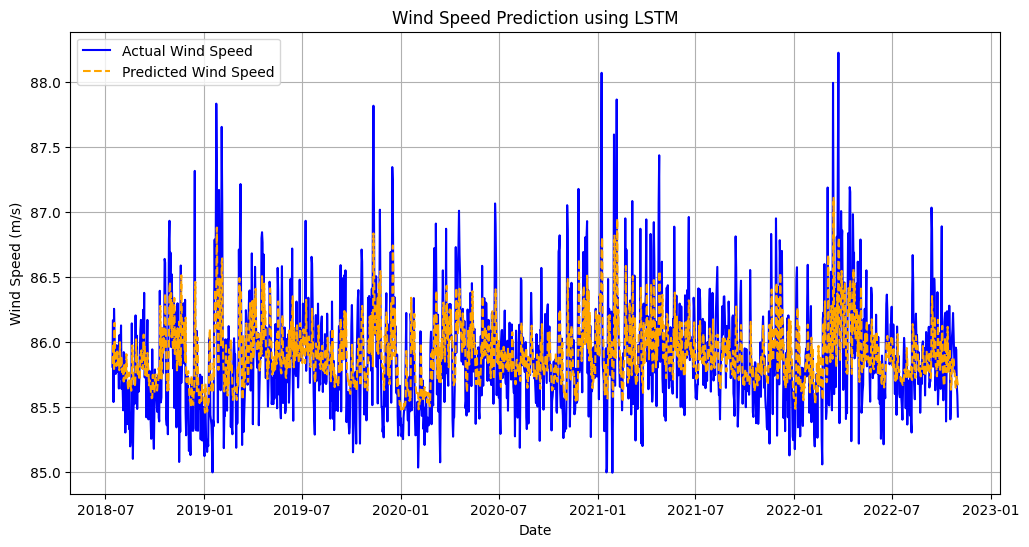

In [47]:
aligned_dates = test_data['DATE'].iloc[sequence_length:].reset_index(drop=True)


# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(aligned_dates, y_test_unscaled, label='Actual Wind Speed', color='blue')
plt.plot(aligned_dates, y_pred_unscaled, label='Predicted Wind Speed', color='orange', linestyle='--')
plt.title('Wind Speed Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.grid()
plt.show()

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculer MAE et MSE
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)

# Afficher les résultats
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

Mean Absolute Error (MAE): 0.2775
Mean Squared Error (MSE): 0.1280
